In [26]:
import sys
sys.path.append("../SpikeCounter")
import numpy as np
import skimage.io as skio
import scipy.ndimage as ndi
import scipy.signal as signal
import scipy.stats as stats
import matplotlib.pyplot as plt
import skimage.transform as transform
from tifffile import imsave
import scipy.ndimage as ndimage
import matplotlib.colors as colors
import matplotlib.patches as patches
import os
from scipy import interpolate, optimize
from skimage import filters, measure, draw, exposure, morphology
from spikecounter.analysis import traces, images
from spikecounter.ui import visualize
from spikecounter import utils
import pandas as pd
from skimage.util import img_as_ubyte
import pickle
import importlib
plt.style.use("../voltage_traces.mplstyle")

In [2]:
importlib.reload(images)

<module 'spikecounter.analysis.images' from '/n/home11/bjia/notebooks/../SpikeCounter/spikecounter/analysis/images.py'>

In [5]:
rootdir = "/n/holyscratch01/cohen_lab/bjia/20211202_stim_probability/"
os.makedirs(os.path.join(rootdir, "analysis"), exist_ok=True)

In [6]:
fs = 10.2

In [7]:
filename = "100850_complements_demo_2s_t1_p1_z1"

In [23]:
img, _ = images.load_image(rootdir, filename, raw=False)

In [25]:
trace = img.mean(axis=(1,2))

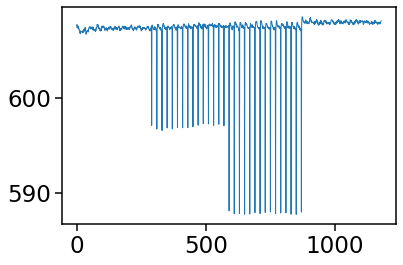

In [28]:
plt.plot(trace[10:-10])

In [27]:
mean_intensity = img.mean(axis=0)
img_mask = mean_intensity > np.percentile(mean_intensity, 90)

(<Figure size 288x288 with 1 Axes>,
 <AxesSubplot:>,
 <matplotlib.image.AxesImage at 0x2b744ce53640>)

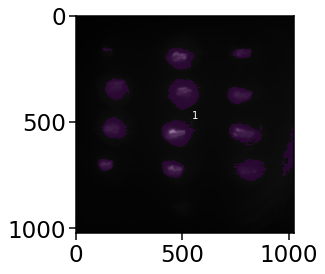

In [36]:
mean_intensity = img.mean(axis=0)
img_mask = mean_intensity > np.percentile(mean_intensity, 90)
fig1, ax1 = plt.subplots(figsize=(4,4))
visualize.display_roi_overlay(mean_intensity, img_mask.astype(np.uint8), ax=ax1)

In [90]:
roi_trace = images.extract_mask_trace(img, mask=img_mask)

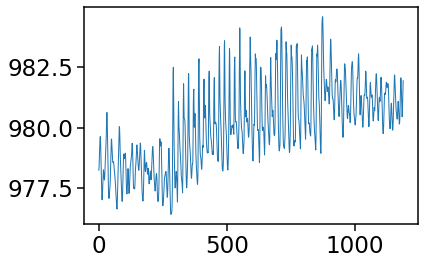

In [91]:
plt.plot(roi_trace)

In [8]:
denoised_img, _ = images.load_image(rootdir, filename, subfolder="denoised", raw=False)

In [9]:
dFF_img = images.get_image_dFF(denoised_img)

In [50]:
utils.display_zstack(dFF_img[500:600], pct_cutoffs=[5,95])

interactive(children=(IntSlider(value=49, description='z', max=99), Dropdown(description='c', options=('all', …

In [74]:
# hearts_mask = morph.binary_dilation(mask_labels > 0, footprint=morph.disk(2))
hearts_mask = mask_labels > 0

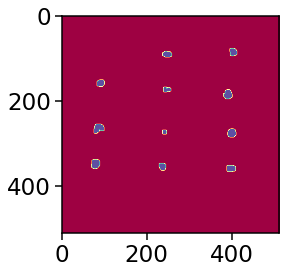

In [75]:
plt.imshow(hearts_mask)

In [76]:
minval = np.percentile(dFF_img[:,hearts_mask], 10)
maxval = np.max(dFF_img)
dFF_vis_8bit = img_as_ubyte(np.maximum((dFF_img-minval)/(maxval-minval), 0))
# dFF_vis_8bit[:,~hearts_mask] = 0

In [77]:
skio.imsave(os.path.join(rootdir, "analysis", "%s_dFF_8bit.tif" % filename), dFF_vis_8bit)

/tmp/ipykernel_37806/3408823860.py:1: UserWarning: /n/holyscratch01/cohen_lab/bjia/20211202_stim_probability/analysis/100850_complements_demo_2s_t1_p1_z1_dFF_8bit.tif is a low contrast image
  skio.imsave(os.path.join(rootdir, "analysis", "%s_dFF_8bit.tif" % filename), dFF_vis_8bit)


In [96]:
mean_intensity_stack = np.tile(mean_intensity, (dFF_img.shape[0], 1,1))

In [97]:
skio.imsave(os.path.join(rootdir, "analysis", filename, "mean_intensity.tif"), img_as_ubyte((mean_intensity_stack.astype(np.uint16)\
                                                                                             -np.min(mean_intensity))/(np.max(mean_intensity)-np.min(mean_intensity))))

FileNotFoundError: [Errno 2] No such file or directory: '/n/holyscratch01/cohen_lab/bjia/20211202_stim_probability/analysis/100850_complements_demo_2s_t1_p1_z1/mean_intensity.tif'

In [19]:
# filename = "101129_complements_demo_1.5s_t1_p1_z1"
with open(os.path.join(rootdir, "denoised/analysis/stim_indices", "%s_stim_indices.pickle" % filename), "rb") as f:
    t_mask = pickle.load(f)

In [12]:
downsampled = skio.imread(os.path.join(rootdir, "downsampled", "%s.tif" % filename))
stimulated_embryos = np.zeros_like(dFF_img, dtype = np.uint8)

In [13]:
mean_downsampled = np.mean(downsampled, axis=0)

In [14]:
std_downsampled = np.std(downsampled, axis=0)

In [15]:
props = measure.regionprops(mask_labels)

In [16]:
roi_traces = images.extract_roi_traces(downsampled, mask_labels)

(<Figure size 864x792 with 1 Axes>,
 <AxesSubplot:>,
 ['#1f77b4',
  '#ff7f0e',
  '#2ca02c',
  '#d62728',
  '#9467bd',
  '#8c564b',
  '#e377c2',
  '#7f7f7f',
  '#bcbd22',
  '#17becf',
  '#1f77b4'])

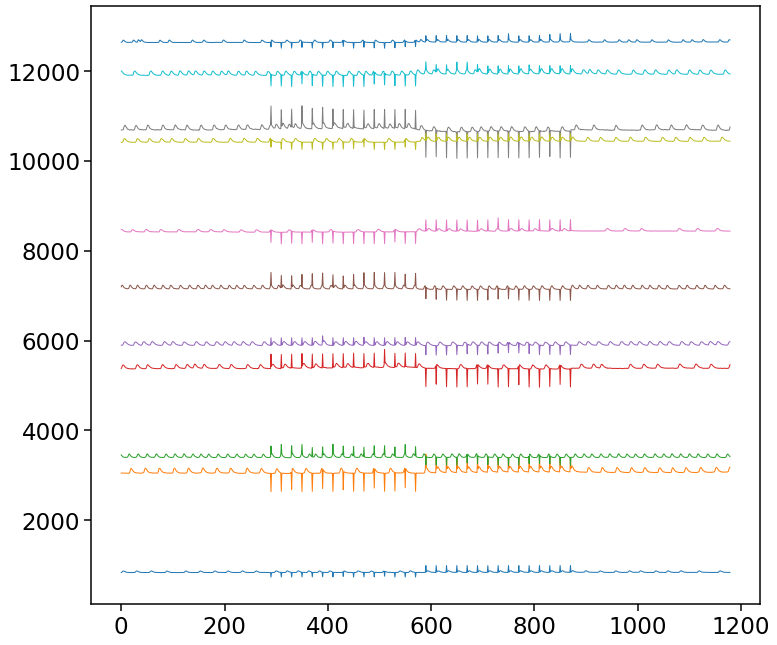

In [17]:
visualize.stackplot(roi_traces)

In [20]:
rising_edges = np.argwhere(np.diff(t_mask.astype(int)) == 1).ravel()

In [45]:
first_group = [2,3,4,5,7]
stimulated_embryos = np.zeros_like(dFF_img, dtype = bool)
for idx, prop in enumerate(props):
    r_c, c_c = prop["centroid"]
    rr, cc = draw.disk((int(np.round(r_c)), int(np.round(c_c))), 40)
    rr2, cc2 = draw.disk((int(np.round(r_c)), int(np.round(c_c))), 35)
    if idx in first_group:
        for t in rising_edges[:15]:
            stimulated_embryos[t, rr, cc] = True
            stimulated_embryos[t, rr2, cc2] = False
    else:
        for t in rising_edges[15:]:
            stimulated_embryos[t, rr, cc] = True
            stimulated_embryos[t, rr2, cc2] = False

#     stimulated_embryos[t_idx] = mask*255

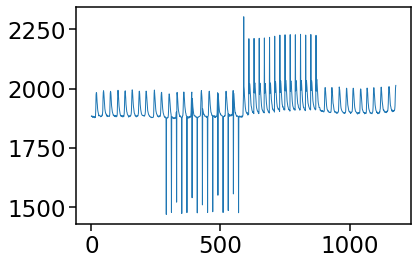

In [127]:
plt.plot(images.extract_mask_trace(downsampled, mask_labels==2))

In [46]:
utils.display_zstack(stimulated_embryos[rising_edges].astype(int), pct_cutoffs=[0,100])

interactive(children=(IntSlider(value=14, description='z', max=29), Dropdown(description='c', options=('all', …

In [47]:
for i in range(4):
    stimulated_embryos[rising_edges+i] = stimulated_embryos[rising_edges]

In [48]:
skio.imsave(os.path.join(rootdir, "analysis", "stim_indication.tif"), stimulated_embryos)

/tmp/ipykernel_164496/204238177.py:1: UserWarning: /n/holyscratch01/cohen_lab/bjia/20211202_stim_probability/analysis/stim_indication.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  skio.imsave(os.path.join(rootdir, "analysis", "stim_indication.tif"), stimulated_embryos)
/tmp/ipykernel_164496/204238177.py:1: UserWarning: /n/holyscratch01/cohen_lab/bjia/20211202_stim_probability/analysis/stim_indication.tif is a low contrast image
  skio.imsave(os.path.join(rootdir, "analysis", "stim_indication.tif"), stimulated_embryos)


In [137]:
bf = transform.downscale_local_mean(skio.imread(os.path.join(rootdir, "Snaps", "101718 RCaMP snap.tif")), (2,2))

In [138]:
bf = np.tile(bf, (dFF_img.shape[0],1,1))

In [144]:
bf = img_as_ubyte(exposure.rescale_intensity(bf, out_range=(0,1)))

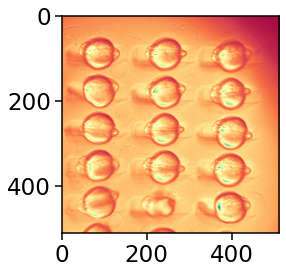

In [146]:
plt.imshow(bf[0])

In [145]:
skio.imsave(os.path.join(rootdir, "analysis", "stim_embryos_brightfield.tif"), bf)

In [10]:
f_s = fs
intensity_threshold = 0.85
band_threshold = 0.7
band_bounds=(0.1,2.5)
opening_size=5
dilation_size = 3
corr_threshold = 0.8
mask_labels, coms, intensity_mask, abs_power, smoothed_band_power, initial_guesses, corr_img = images.identify_hearts(dFF_img, 11, full_output=True,\
                        opening_size=opening_size, dilation_size=3, band_bounds=band_bounds,\
                        corr_threshold=corr_threshold, intensity_threshold=intensity_threshold,\
                        band_threshold=band_threshold, f_s=f_s)

(11, 2)


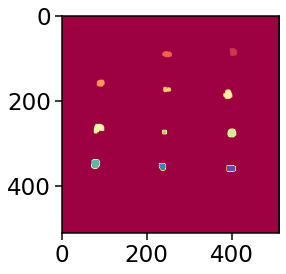

In [11]:
plt.imshow(mask_labels)

In [467]:
skio.imsave(os.path.join(rootdir, "analysis", "base_mask.tif"), labelled)

<ipython-input-467-5a4497fbccdb>:1: UserWarning: /n/holyscratch01/cohen_lab/bjia/20211025_widefield_frgeco_cochr/analysis/base_mask.tif is a low contrast image
  skio.imsave(os.path.join(rootdir, "analysis", "base_mask.tif"), labelled)


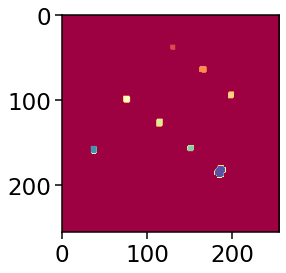

In [334]:
plt.imshow(mask_labels)

In [335]:
dFF_traces = []

In [336]:
mask = mask_labels
for i in range(1, np.max(mask)+1):
    dff_trace = images.extract_mask_trace(dFF_img, mask=np.tile(mask==i, (dFF_img.shape[0], 1, 1)))
    dFF_traces.append(dff_trace)

In [337]:
dFF_traces = np.array(dFF_traces)

In [338]:
dFF_traces.shape

(8, 1500)

In [339]:
stims = traces.find_stim_starts(t_mask, 1, dt=1/fs)

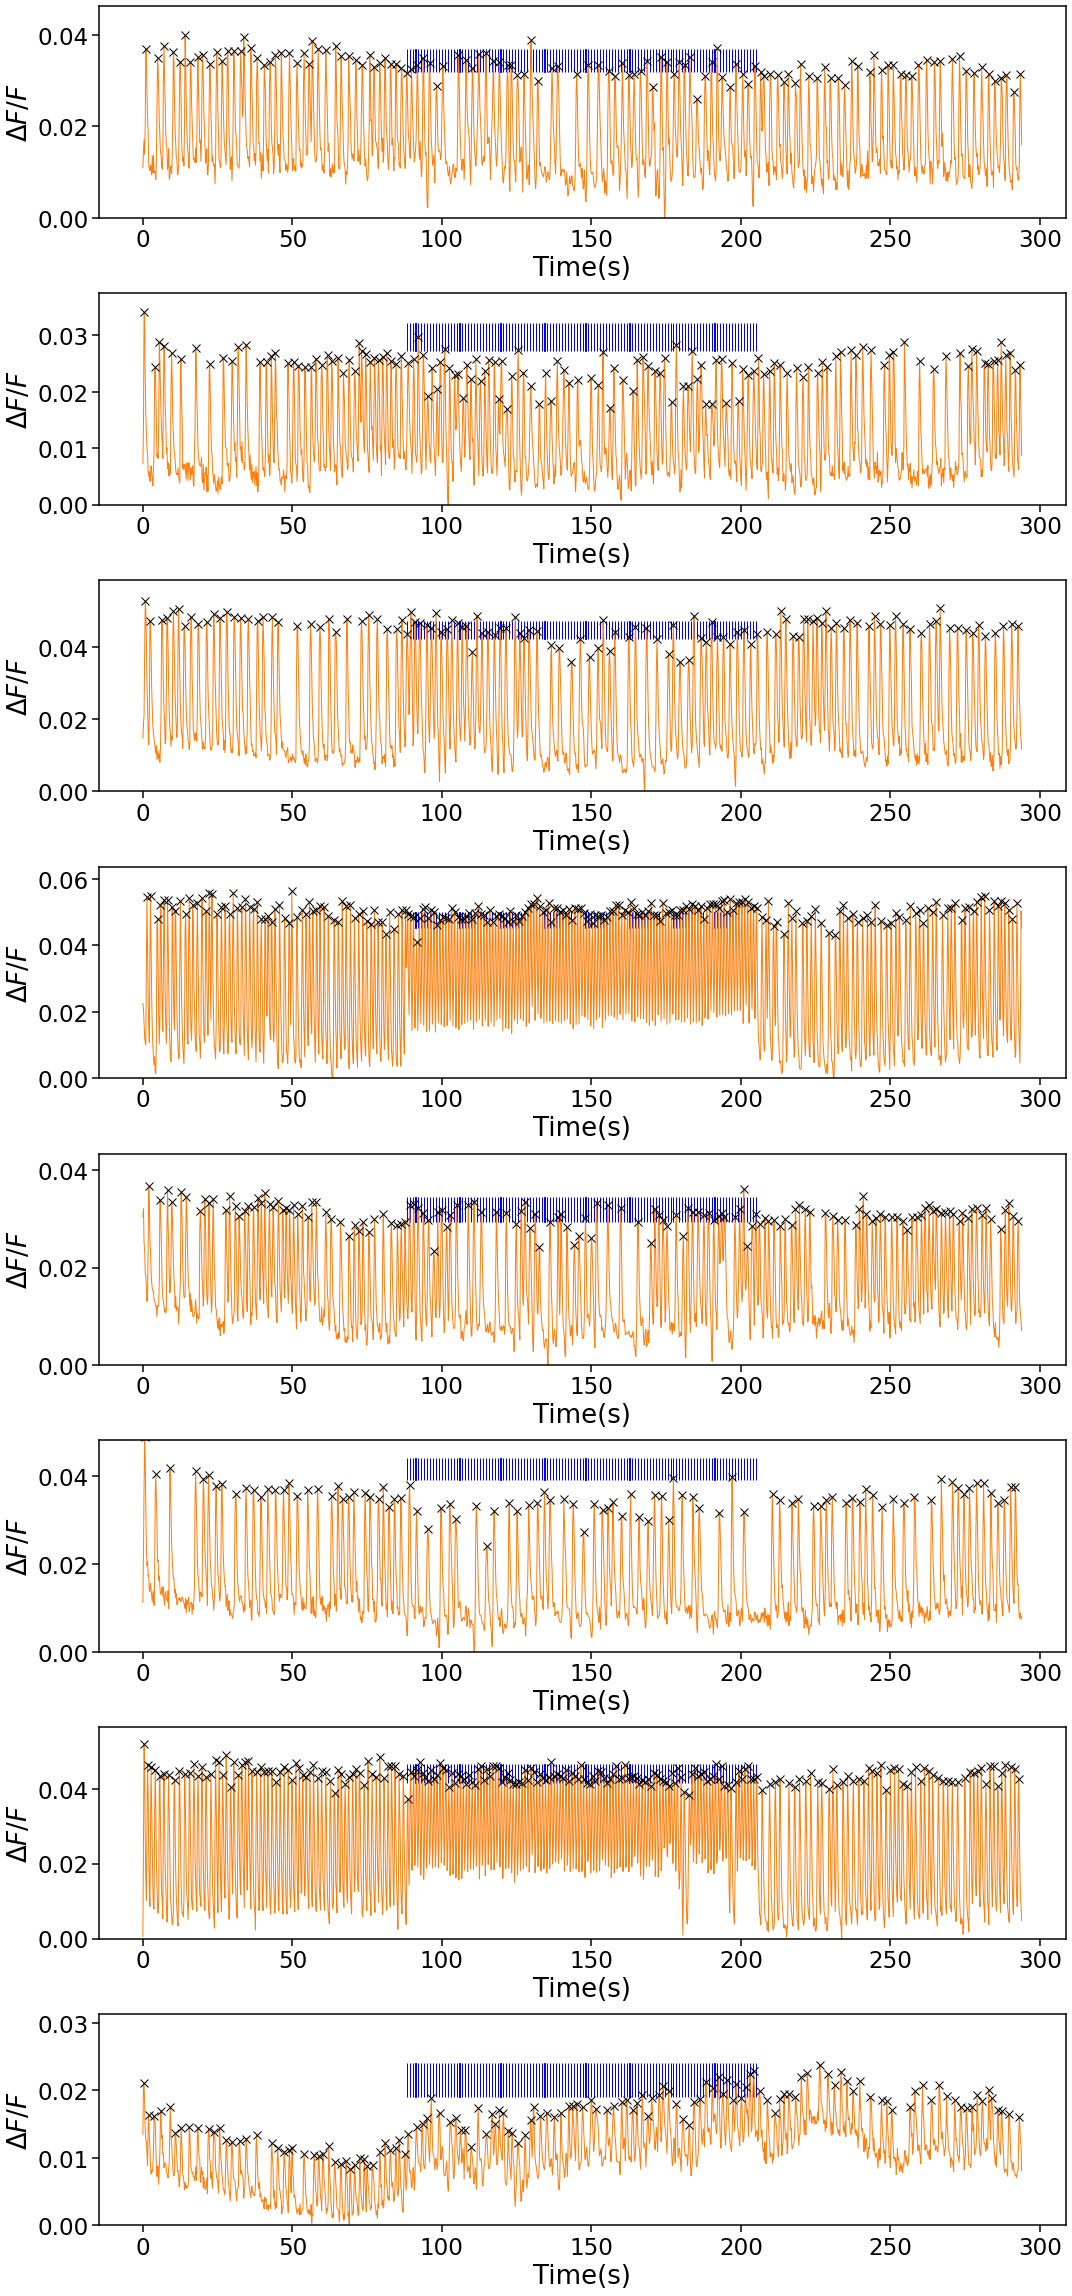

In [340]:
fig1, axes = plt.subplots(dFF_traces.shape[0], 1, figsize=(15,dFF_traces.shape[0]*4))
axes = axes.ravel()
pk_arrays = []

for i, ax in enumerate(axes):
    dff_trace = dFF_traces[i,:]
    dff_trace -= np.min(dff_trace)
    pks,_ = signal.find_peaks(dff_trace, prominence=np.percentile(dff_trace,95)*0.2)
    pk_arrays.append(pks)
    ax.plot(np.arange(dFF_img.shape[0])/fs, dff_trace, color="C1")
    ax.plot(pks/fs, dff_trace[pks], "kx")
    for st in stims:
        r = patches.Rectangle((st, np.max(dff_trace)*0.8), 0.02, 0.005, color="blue")
        ax.add_patch(r)
    ax.set_xlabel("Time(s)")
    ax.set_ylabel(r"$\Delta F/F$")
    ax.set_ylim(0, np.percentile(dff_trace,99)+0.01)
plt.tight_layout()
plt.savefig(os.path.join(rootdir, "analysis", filename, "traces_peaks.tif"))

Check frequencies before and after stimulation

In [341]:
first_stim = np.min(stims*fs)
last_stim = np.max(stims*fs)

In [342]:
len(pk_arrays)

8

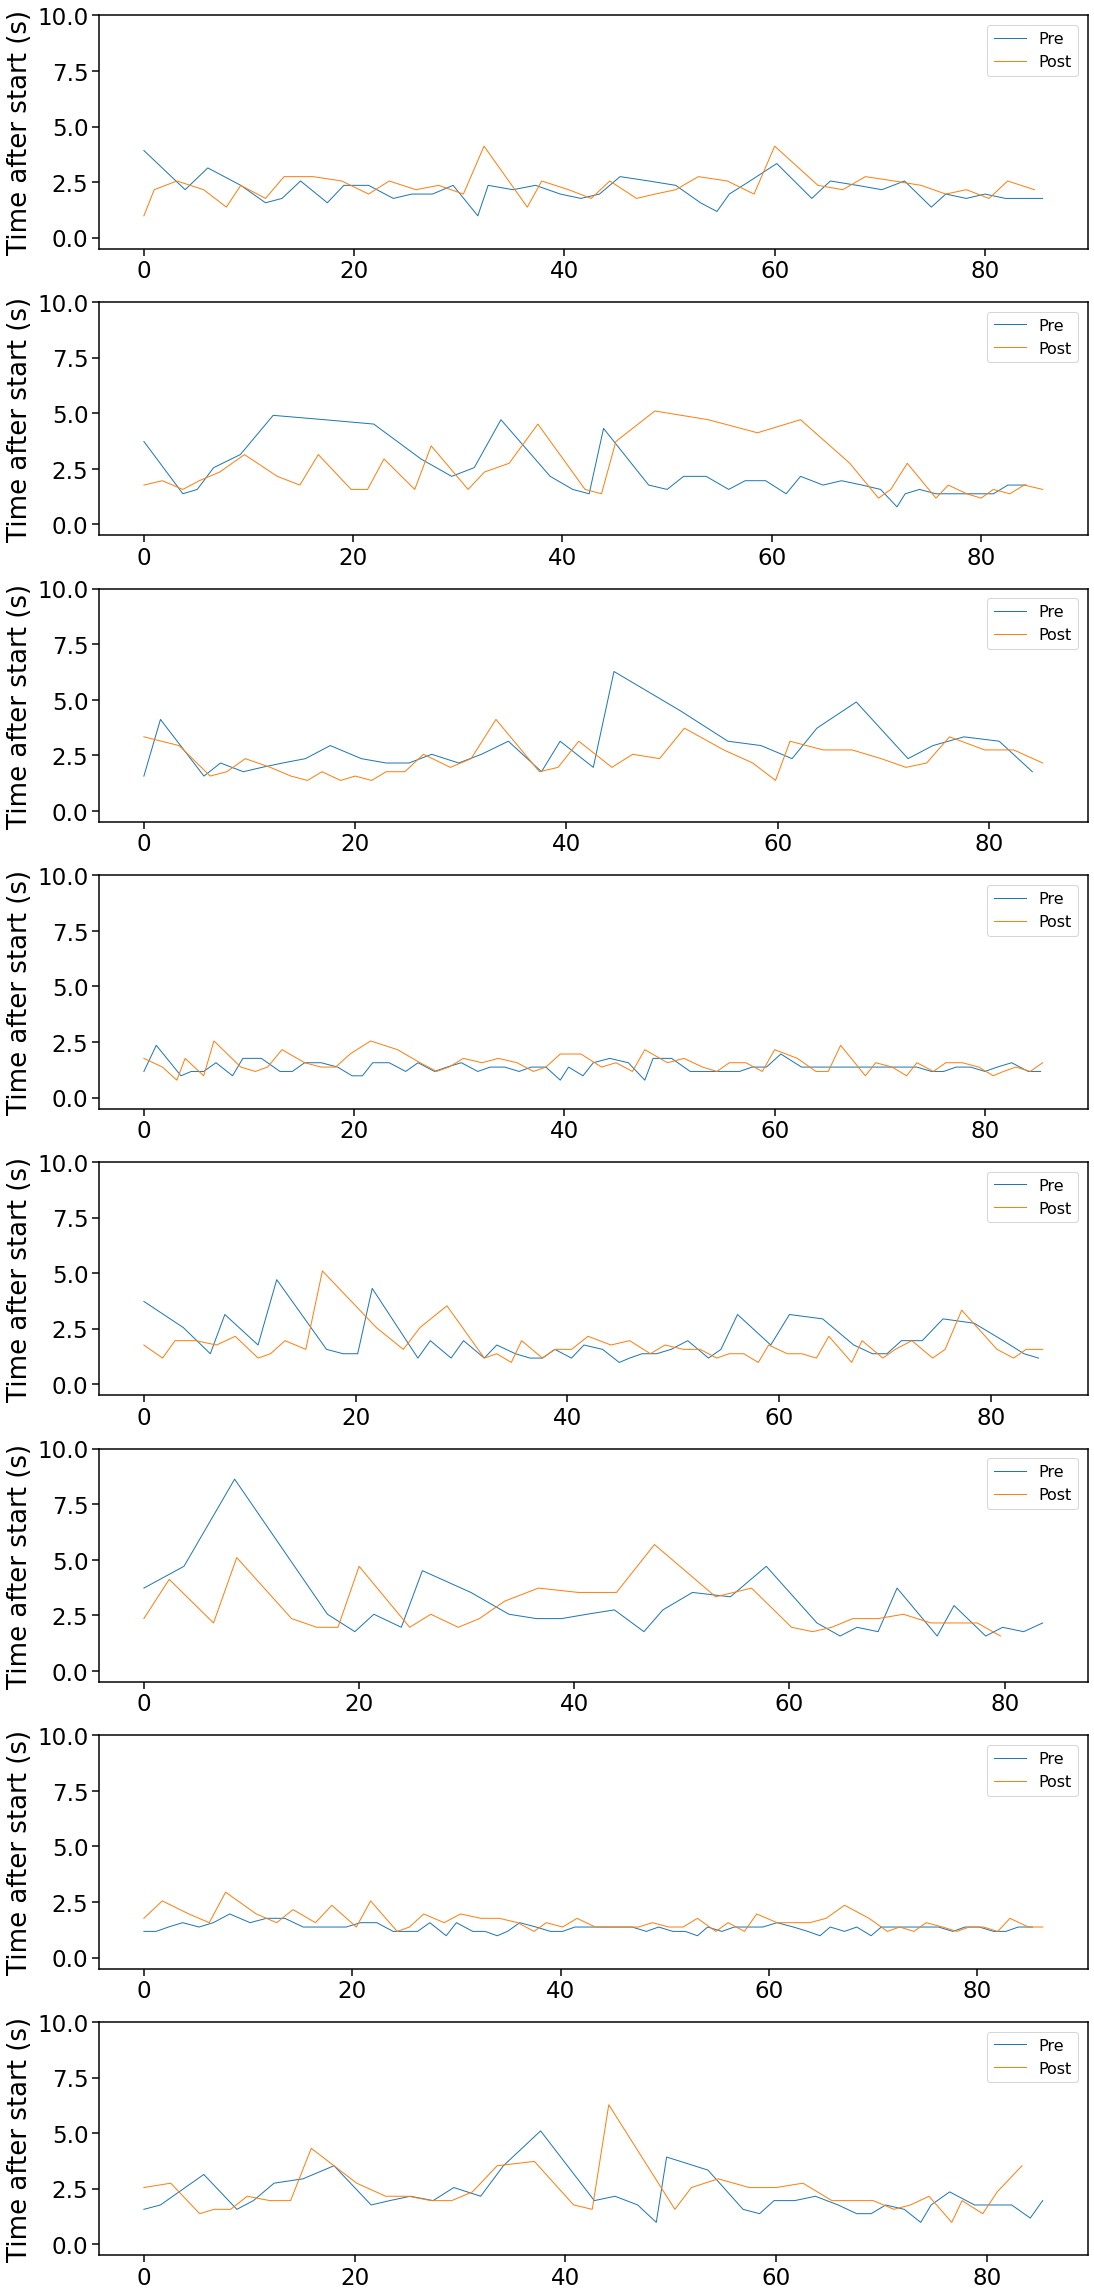

In [343]:
mean_freq_before = []
mean_freq_after = []
fig1, axes = plt.subplots(dFF_traces.shape[0], 1, figsize=(15,dFF_traces.shape[0]*4))
axes = axes.ravel()
for i in range(dFF_traces.shape[0]):
    if i not in []:
        pks = pk_arrays[i]
        pks_before = pks[pks < first_stim]
        pks_after = pks[pks > last_stim]

        isi_before = np.diff(pks_before)
        isi_after = np.diff(pks_after)

        axes[i].plot(pks_before[:-1]/fs-np.min(pks_before[:-1]/fs), isi_before/fs, label="Pre")
        axes[i].plot(pks_after[:-1]/fs-np.min(pks_after[:-1]/fs), isi_after/fs, label="Post")
        mean_freq_before.append(1/np.mean(isi_before/fs))
        mean_freq_after.append(1/np.mean(isi_after/fs))
        axes[i].set_ylim(-0.5, 10)
        axes[i].set_ylabel("ISI (s)")
        axes[i].set_ylabel("Time after start (s)")
        axes[i].legend()
plt.tight_layout()
plt.savefig(os.path.join(rootdir, "analysis", filename, "isi_traces.tif"))

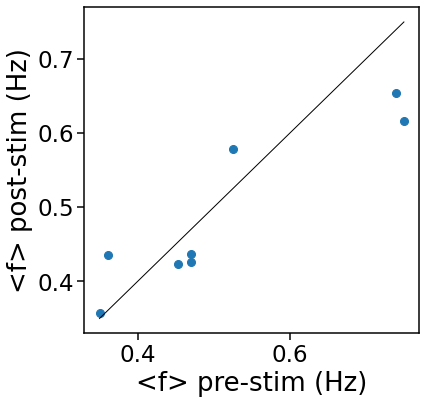

In [344]:
fig1, ax1 = plt.subplots(figsize=(6,6))
ax1.scatter(mean_freq_before, mean_freq_after)
x = np.linspace(np.min(mean_freq_before), np.max(mean_freq_before), 100)
ax1.plot(x,x, color="black")
ax1.set_xlabel("<f> pre-stim (Hz)")
ax1.set_ylabel("<f> post-stim (Hz)")
plt.savefig(os.path.join(rootdir, "analysis", filename, "f_pre_post.tif"))

In [345]:
mean_freq_after_arb_cutoff = {}
cutoffs = [15, 30, 45, 60]
for c in cutoffs:
    mean_freq_after_arb_cutoff[c] = []
    for i in range(dFF_traces.shape[0]):
        if i not in []:
            pks = pk_arrays[i]
            pks_after = pks[pks > last_stim + c*fs]
            isi_after = np.diff(pks_after)
            mean_freq_after_arb_cutoff[c].append(1/np.mean(isi_after/fs))

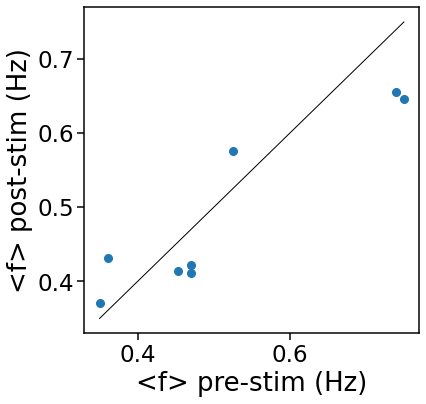

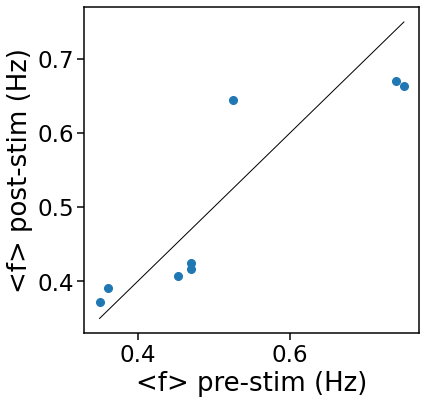

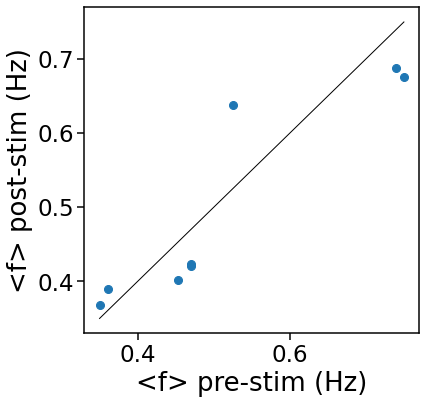

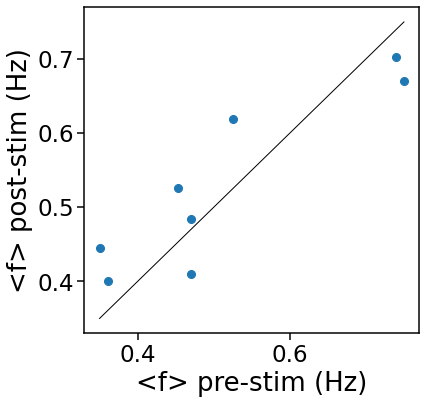

In [346]:
for c in cutoffs:
    fig1, ax1 = plt.subplots(figsize=(6,6))
    ax1.scatter(mean_freq_before, mean_freq_after_arb_cutoff[c])
    x = np.linspace(np.min(mean_freq_before), np.max(mean_freq_before), 100)
    ax1.plot(x,x, color="black")
    ax1.set_xlabel("<f> pre-stim (Hz)")
    ax1.set_ylabel("<f> post-stim (Hz)")

Plot different conditions together

In [347]:
data_by_sample[filename] = (mean_freq_before, mean_freq_after)
labels_by_sample[filename] = (120, 1)

In [349]:
labels_list = []
for k in labels_by_sample.keys():
    labels_list.append((k, labels_by_sample[k][0], labels_by_sample[k][1]))

In [358]:
expt_data = pd.DataFrame(labels_list, columns=["filename", "stim_duration_s", "stim_freq_hz"])
expt_data = expt_data.reset_index().set_index(["stim_duration_s", "stim_freq_hz"])
del(expt_data["index"])

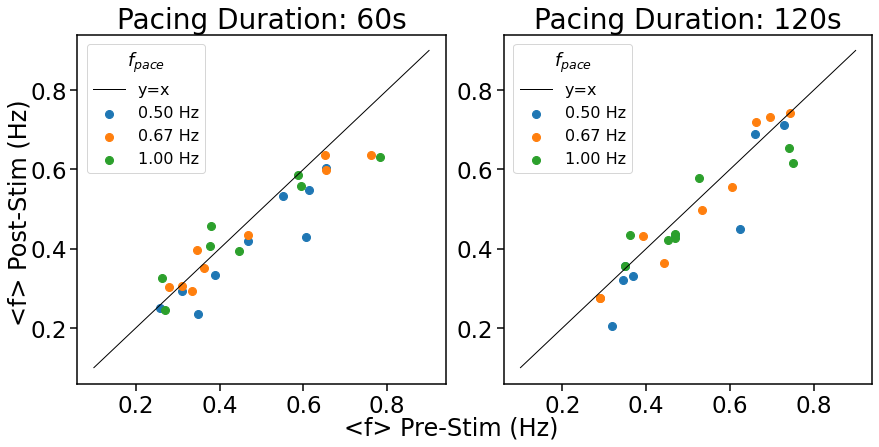

In [387]:
fig1, axes = plt.subplots(1,2, figsize=(12,6))
axes = axes.ravel()
for idx1, dur in enumerate(expt_data.index.unique("stim_duration_s")):
    dur_info = expt_data.loc[dur]
    axes[idx1].set_title("Pacing Duration: %ds" % dur)
    x = np.linspace(0.1, 0.9, 100)
    
    for idx2, freq in enumerate(dur_info.index.unique()):
        fname = dur_info.loc[freq].iloc[0]
        sample_data = data_by_sample[fname]
        axes[idx1].scatter(sample_data[0], sample_data[1], label = "%.2f Hz" % freq)
    axes[idx1].plot(x,x, color="black", label="y=x")
    axes[idx1].legend(title=r"$f_{pace}$", title_fontsize=18)
fig1.text(0, 0.5, "<f> Post-Stim (Hz)", rotation=90, fontsize=24, horizontalalignment="center", verticalalignment="center")
fig1.text(0.5, 0, "<f> Pre-Stim (Hz)", fontsize=24, horizontalalignment="center", verticalalignment="center")

plt.tight_layout()
plt.savefig(os.path.join(rootdir, "analysis", "frequency_pacing_dependence.tif"))